# Reproduce the Laplace-approximated NAM
## References
```  
@misc{bouchiat2023laplaceapproximated,
      title={Laplace-Approximated Neural Additive Models: Improving Interpretability with Bayesian Inference}, 
      author={Kouroche Bouchiat and Alexander Immer and Hugo Yèche and Gunnar Rätsch and Vincent Fortuin},
      year={2023},
      eprint={2305.16905},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}
```

In [4]:
import time 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from LANAM.models import LaNAM, BayesianLinearRegression

from LANAM.config.default import defaults

from LANAM.trainer.training import *
from LANAM.trainer.marglik_training import *

from LANAM.data.generator import *
from LANAM.data.toydataset import ToyDataset

from LANAM.utils.plotting import * 

import matplotlib.pyplot as plt 
import numpy as np


from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

from nam.config import defaults as namDefaults
from nam.models import NAM, get_num_units
from nam.trainer import LitNAM
from nam.utils import *
"""
Reference:
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\nReference:\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [27]:
import torch

from backpack import backpack, extend
from backpack.extensions import BatchGrad
from backpack.extensions.firstorder.base import FirstOrderModuleExtension

from LANAM.models.activation import ExU, BatchGradExU

# make deterministic
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

extension = BatchGrad()
extension.set_module_extension(ExU, BatchGradExU())

batch_size = 10
batch_axis = 0
input_size = 4

inputs = torch.randn(batch_size, input_size, device=device)
targets = torch.randint(0, 2, (batch_size,), device=device)

reduction = ["mean", "sum"][1]
my_module = ExU(input_size, 2).to(device)
lossfunc = torch.nn.CrossEntropyLoss(reduction=reduction).to(device)

grad_batch_autograd = []

for input_n, target_n in zip(
    inputs.split(1, dim=batch_axis), targets.split(1, dim=batch_axis)
):
    loss_n = lossfunc(my_module(input_n), target_n)
    grad_n = torch.autograd.grad(loss_n, [my_module.weights])[0]
    grad_batch_autograd.append(grad_n)

grad_batch_autograd = torch.stack(grad_batch_autograd)

print("weight.shape:             ", my_module.weights.shape)
print("grad_batch_autograd.shape:", grad_batch_autograd.shape)

my_module = extend(my_module)
lossfunc = extend(lossfunc)

loss = lossfunc(my_module(inputs), targets)

with backpack(extension):
    loss.backward()

grad_batch_backpack = my_module.weight.grad_batch

print("weight.shape:             ", my_module.weight.shape)
print("grad_batch_backpack.shape:", grad_batch_backpack.shape)


weight.shape:              torch.Size([4, 2])
grad_batch_autograd.shape: torch.Size([10, 4, 2])


AttributeError: 'ExUDerivatives' object has no attribute 'param_mjp'

In [3]:
%reload_ext autoreload 
%autoreload 2

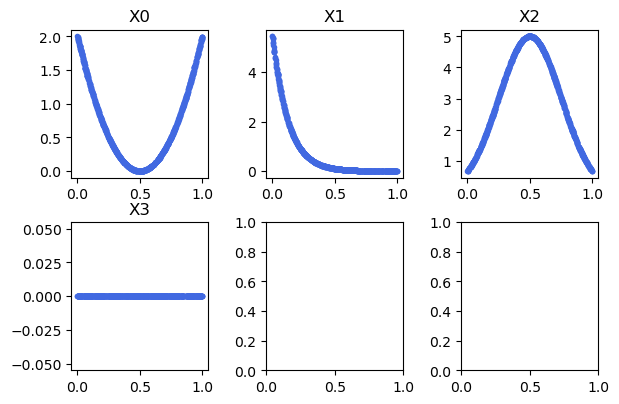

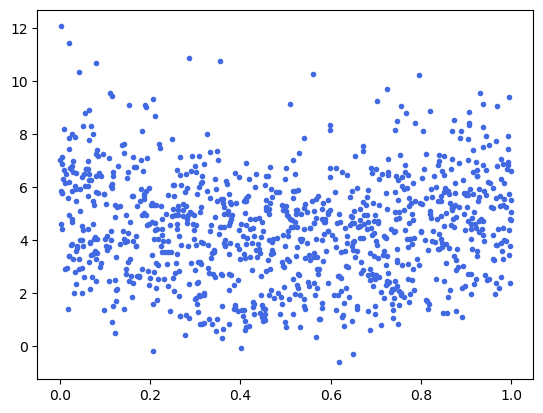

In [4]:
cfg = defaults()

gen_funcs, gen_func_names = task()
in_features = len(gen_funcs)
sigma = 0.7

trainset = ToyDataset(gen_funcs, gen_func_names, num_samples=1000, sigma=sigma)
valset = ToyDataset(gen_funcs, gen_func_names, num_samples=200, sigma=sigma)
testset = ToyDataset(gen_funcs, gen_func_names, num_samples=50, use_test=True)
trainset.plot()

In [8]:
model = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='full', subset_of_weights='all')
print(model)
start = time.time()
model, margliks, losses, perfs = marglik_training(model, trainset.loader, trainset.loader_fnn, 'regression', n_epochs=200, use_wandb=False, optimizer_kwargs={'lr': 1e-2})
end = time.time()
print(f'Training time: {end-start:.3f}s')

LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.614, epoch_perf= 0.484
tensor([0.8084, 0.4714, 0.3382, 0.9583], grad_fn=<ExpBackward0>) tensor([0.4206, 0.4319, 0.4260, 0.3304], grad_fn=<ExpBackward0>)
MARGLIK: finished training. Recover best model and fit Laplace.
Training time: 19.152s


In [9]:
print(model.additive_sigma_noise)

tensor(0.8087, grad_fn=<SqrtBackward0>)


MSE loss:  0.0522
Additive sigma noise:  0.6540
Individual sigma noise: [0.17686781 0.18651323 0.18147913 0.10917957]


(<Figure size 640x480 with 1 Axes>, <Figure size 800x200 with 4 Axes>)

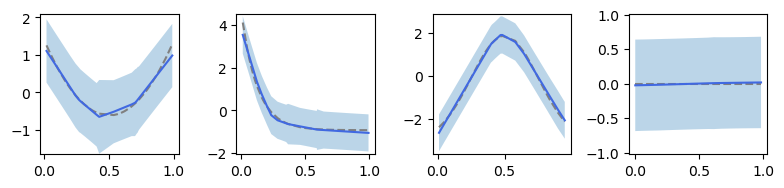

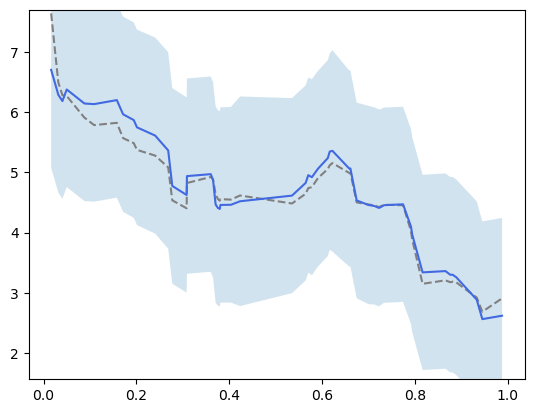

In [10]:
plot_predictive_posterior(model, testset)

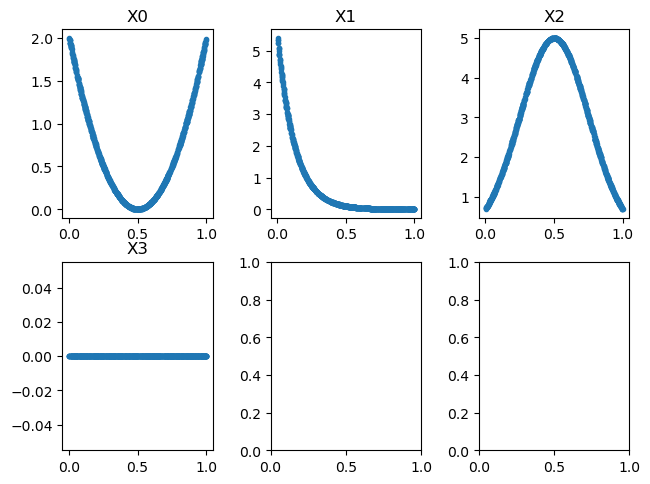

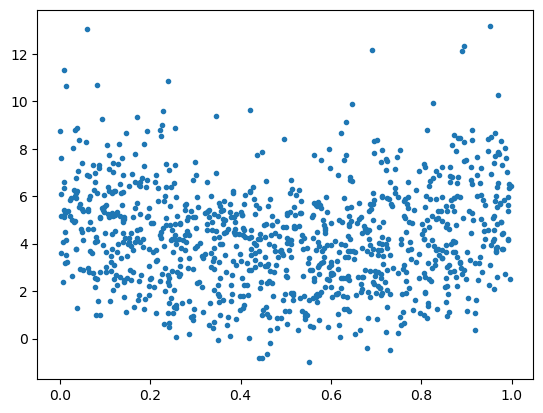

In [7]:
cfg = defaults()

gen_funcs, gen_func_names = task()
in_features = len(gen_funcs)
sigma = 1.0

trainset = ToyDataset(gen_funcs,
                    gen_func_names, 
                    num_samples=1000, 
                    sigma=sigma)
valset = ToyDataset(gen_funcs,
                    gen_func_names, 
                    num_samples=200, 
                    sigma=sigma)
testset = ToyDataset(gen_funcs, 
                    gen_func_names, 
                    num_samples=50, 
                    use_test=True)
trainset.plot()

In [8]:
model_ph = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='kron')
print(model_ph)

LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)


In [9]:
loss = train(cfg, model_ph, trainset.loader, valset.loader)
model_ph.fit(loss, trainset.loader_fnn)

=============EPOCH 1==============
loss_train:  7.684, loss_val:  5.077
=============EPOCH 101==============
loss_train:  1.044, loss_val:  1.210
=============EPOCH 201==============
loss_train:  1.009, loss_val:  1.179
=============EPOCH 301==============
loss_train:  0.985, loss_val:  1.159
Finished Training.


In [10]:
print(f'prior_precision: {model_ph.prior_precision}, sigma_noise: {model_ph.sigma_noise}')

prior_precision: tensor([1., 1., 1., 1.]), sigma_noise: tensor([1., 1., 1., 1.])


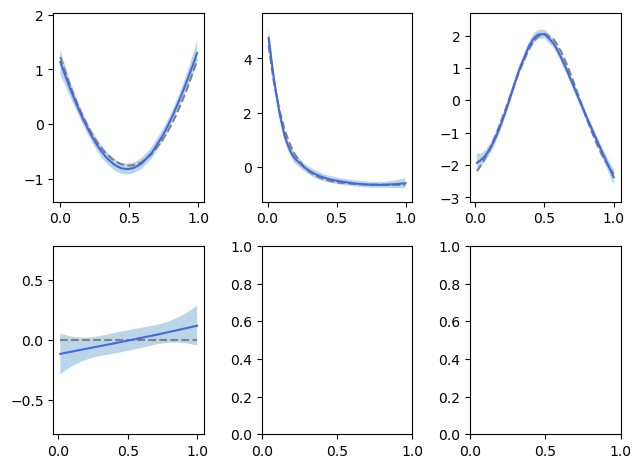

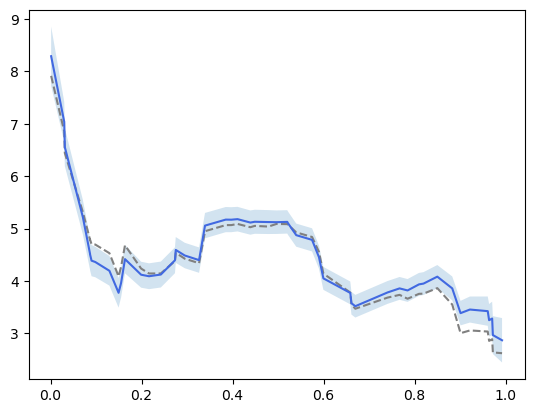

In [11]:
plot_predictive_posterior(model_ph, testset)

In [12]:
# la-nam
n_epochs = 1000
log_prior, log_sigma = torch.ones(in_features, requires_grad=True), torch.ones(in_features, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - model_ph.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
print(f'Finish post-hoc hyperparameter tuning. prior_precision: {model_ph.prior_precision}, sigma_noise: {model_ph.sigma_noise}')

Finish post-hoc hyperparameter tuning. prior_precision: tensor([0.0512, 0.0289, 0.0271, 0.0631], grad_fn=<ExpBackward0>), sigma_noise: tensor([0.4499, 0.5717, 0.5699, 0.3820], grad_fn=<ExpBackward0>)


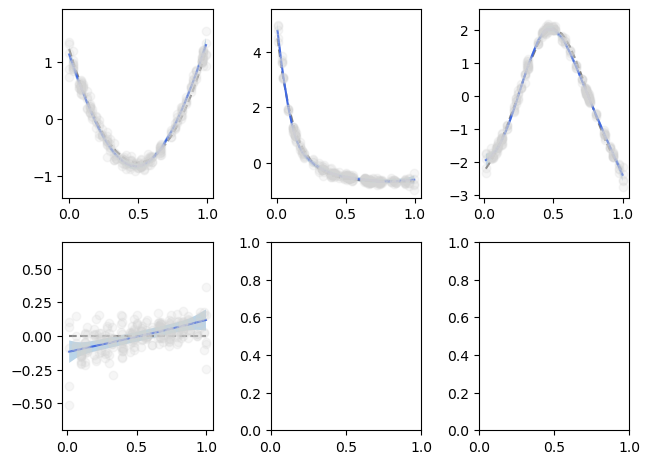

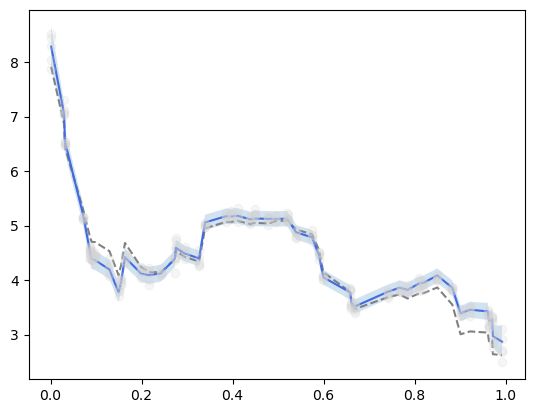

In [13]:
plot_predictive_posterior(model_ph, testset, sampling=True)

In [14]:
model_ol = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='full')
start = time.time()
model_ol, margliks, losses = marglik_training(model_ol, trainset.loader, trainset.loader_fnn, 'regression', n_epochs=400, optimizer_kwargs={'lr': 1e-2})
end = time.time()
print(f'Training time: {end-start:.3f}s')

EPOCH=1: epoch_loss= 9.569, epoch_perf= 9.389
EPOCH=51: epoch_loss= 1.111, epoch_perf= 1.105
EPOCH=101: epoch_loss= 1.064, epoch_perf= 1.057
EPOCH=151: epoch_loss= 1.048, epoch_perf= 1.042
EPOCH=201: epoch_loss= 1.005, epoch_perf= 0.999
EPOCH=251: epoch_loss= 0.986, epoch_perf= 0.980
EPOCH=301: epoch_loss= 1.008, epoch_perf= 1.001
EPOCH=351: epoch_loss= 1.001, epoch_perf= 0.995
MARGLIK: finished training. Recover best model and fit Laplace.
Training time: 35.782s


In [15]:
print(f'prior_precision: {model_ol.prior_precision}, sigma_noise: {model_ol.sigma_noise}')

prior_precision: tensor([0.0742, 0.0334, 0.0307, 0.1632], grad_fn=<ExpBackward0>), sigma_noise: tensor([0.4574, 0.5703, 0.5703, 0.3599], grad_fn=<ExpBackward0>)


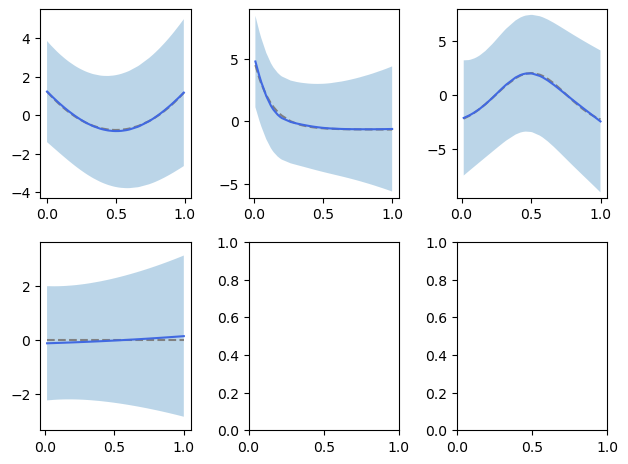

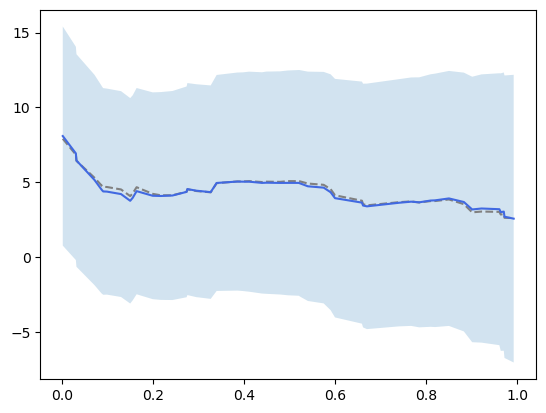

In [16]:
plot_predictive_posterior(model_ol, testset)

In [18]:
from nam.models.activation import ExU

In [19]:
in_features=1
out_features=64
exu=ExU(in_features, out_features)
print(exu.input0)

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-03/6a700484/lib/python3.10/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


AttributeError: 'ExU' object has no attribute 'input0'